# Introduction #

Доброго дня!

Меня зовут **Васюхин Артём**, я студент XV когорты курса DS+ "Яндекс.Практикум" и в этом проекте мы рассмотрим данные о сердечно-сосудистых заболеваниях (далее - ССЗ), которые продолжают оставаться главной причиной смертности во всём мире.

**Наша задача** - создать модель, которая бы на основе данных анализов предсказывала вероятность возникновения ССЗ у пациента.

## Import libraries and previous data checking ##

In [1]:
#!pip install ydata_profiling
#!pip install hyperopt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from pandas_profiling import ProfileReport
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

import joblib
from pickle import dump, load

In [2]:
test_data = pd.read_csv('test_hdp.csv')
train_data = pd.read_csv('train_hdp.csv')
subsample = pd.read_csv('sample_submission.csv')

display(train_data.head())
display(test_data.head())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


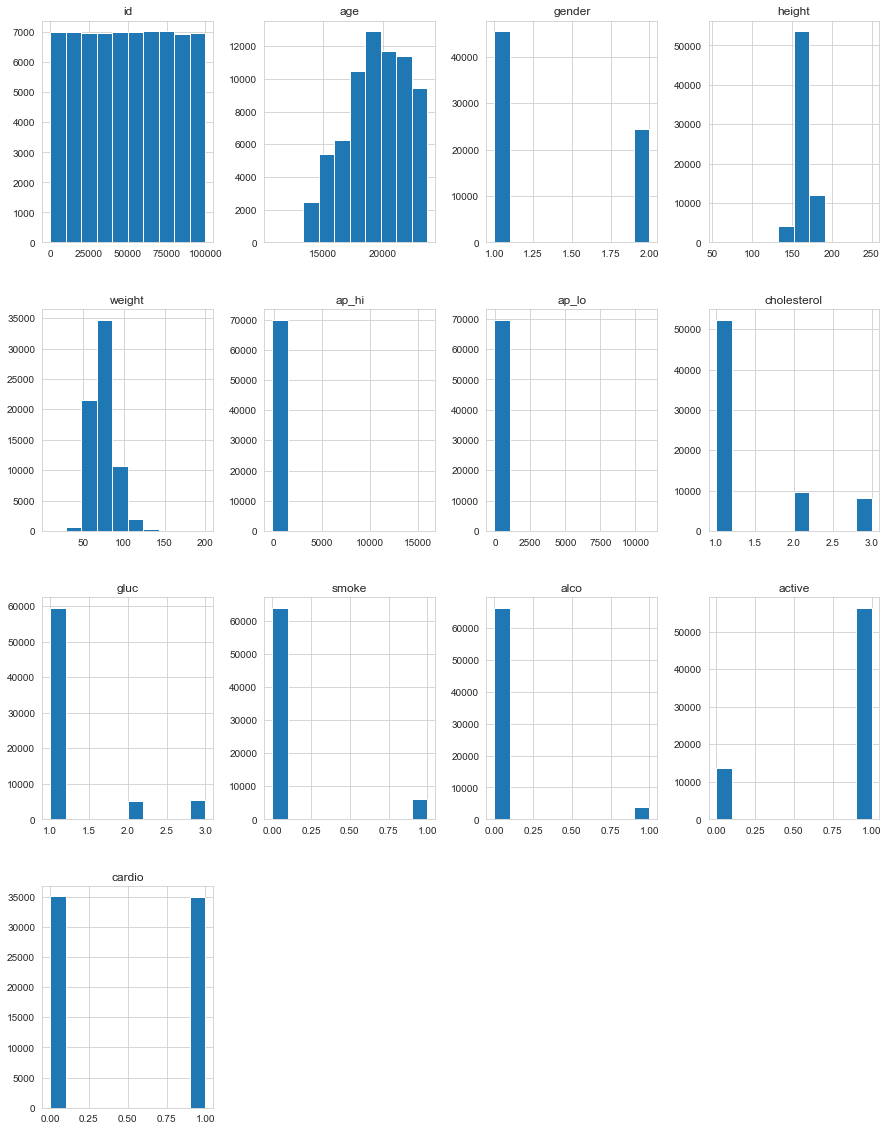

In [3]:
train_data.hist(figsize=(15,20));

# EDA #

In [4]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
train_data['weight'] = train_data['weight'].astype('int64')
train_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1
3,3,17623,2,169,82,150,100,1,1,0,0,1,1
4,4,17474,1,156,56,100,60,1,1,0,0,0,0


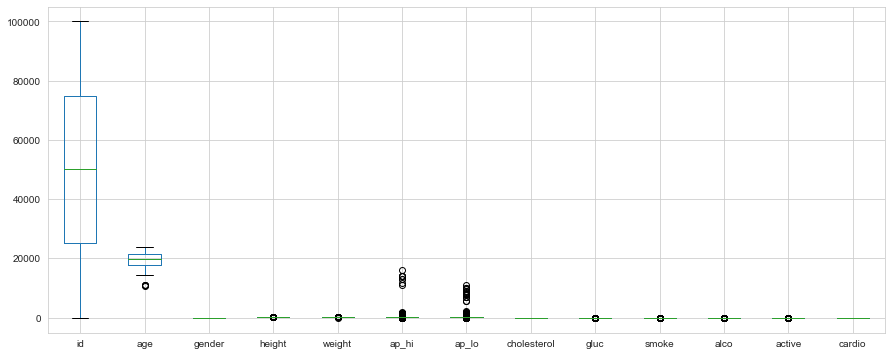

In [6]:
train_data.boxplot(figsize=(15,6));

## id ##

In [7]:
# удалим ненужную колонку id
train_data = train_data.drop('id', axis=1)
test_data = test_data.drop('id', axis=1)

display(train_data.head(5))
display(test_data.head(5))

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62,110,80,1,1,0,0,1,0
1,20228,1,156,85,140,90,3,1,0,0,1,1
2,18857,1,165,64,130,70,3,1,0,0,0,1
3,17623,2,169,82,150,100,1,1,0,0,1,1
4,17474,1,156,56,100,60,1,1,0,0,0,0


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,18888,1,154,85.0,130,80,1,1,0,0,1
1,19042,2,170,69.0,130,90,1,1,0,0,1
2,20432,1,160,70.0,120,75,1,1,0,0,0
3,18133,2,185,94.0,130,90,1,1,0,0,1
4,16093,2,170,76.0,120,80,1,1,0,0,1


## age ##

In [8]:
def boxplot_col(column):
    train_data.boxplot(column, figsize=(10, 5));
    return boxplot_col

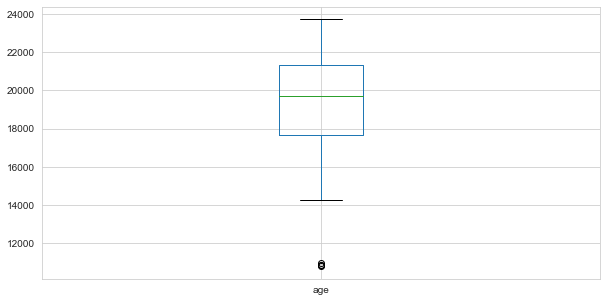

In [9]:
boxplot_col('age');

In [10]:
train_data.query('age < 12000')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6219,10878,1,175,59,120,80,1,1,0,0,1,0
22343,10798,2,175,92,100,60,1,1,0,0,1,0
30666,10859,1,159,59,120,80,1,1,0,0,1,0
55905,10964,1,160,59,110,70,1,1,0,0,1,0


In [11]:
train_data = train_data.query('age > 12000')

In [12]:
train_data['age'] = (train_data['age'] / 365).astype('int')
test_data['age'] = (test_data['age'] / 365).astype('int')
train_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62,110,80,1,1,0,0,1,0
1,55,1,156,85,140,90,3,1,0,0,1,1
2,51,1,165,64,130,70,3,1,0,0,0,1
3,48,2,169,82,150,100,1,1,0,0,1,1
4,47,1,156,56,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52,2,168,76,120,80,1,1,1,0,1,0
69996,61,1,158,126,140,90,2,2,0,0,1,1
69997,52,2,183,105,180,90,3,1,0,1,0,1
69998,61,1,163,72,135,80,1,2,0,0,0,1


<function __main__.boxplot_col(column)>

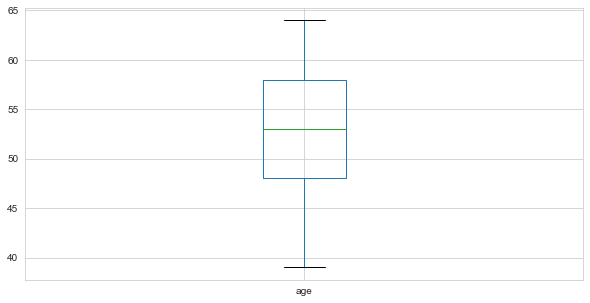

In [13]:
boxplot_col('age')

<AxesSubplot:>

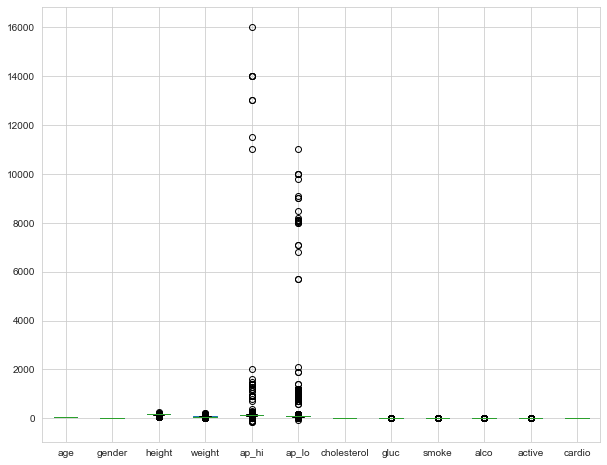

In [14]:
train_data.boxplot(figsize=(10,8))

## gender ##

In [15]:
train_data['gender'] = train_data['gender'].replace([1, 2], [0, 1])

In [16]:
train_data.head(20)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62,110,80,1,1,0,0,1,0
1,55,0,156,85,140,90,3,1,0,0,1,1
2,51,0,165,64,130,70,3,1,0,0,0,1
3,48,1,169,82,150,100,1,1,0,0,1,1
4,47,0,156,56,100,60,1,1,0,0,0,0
5,60,0,151,67,120,80,2,2,0,0,0,0
6,60,0,157,93,130,80,3,1,0,0,1,0
7,61,1,178,95,130,90,3,3,0,0,1,1
8,48,0,158,71,110,70,1,1,0,0,1,0
9,54,0,164,68,110,60,1,1,0,0,0,0


## ap_hi ##

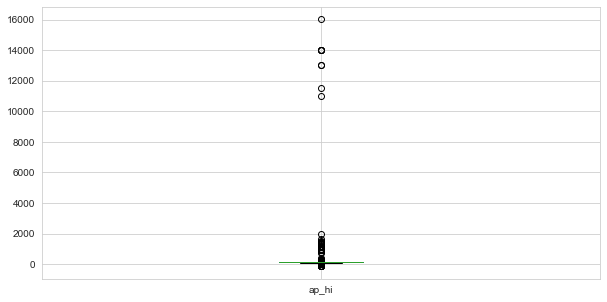

In [17]:
boxplot_col('ap_hi');

In [18]:
train_data.query('ap_hi > 300')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1876,41,0,160,60,902,60,1,1,0,0,1,0
2014,62,1,167,59,906,0,1,1,0,0,1,0
4817,39,0,168,63,909,60,2,1,0,0,1,0
7763,57,0,175,80,11500,90,1,1,0,0,1,1
8915,51,0,164,75,1420,80,2,1,0,0,1,1
9557,62,0,155,87,701,110,1,1,0,0,1,1
13895,43,0,168,72,1500,80,1,1,0,0,1,1
17713,61,1,163,50,907,70,3,3,0,0,1,1
23867,44,0,161,92,906,0,2,1,0,0,1,1
25464,43,1,169,75,14020,80,2,1,0,0,1,1


In [19]:
train_data.query('ap_hi < 300').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
67710,53,1,168,75,240,140,3,1,0,0,1,1
69329,54,0,145,62,240,130,1,1,0,0,0,1
42725,50,1,165,76,240,100,1,1,0,0,1,1
32560,58,1,176,98,240,110,1,1,1,0,1,1
26053,61,0,166,102,240,130,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16021,60,1,161,90,-115,70,1,1,0,0,1,0
25240,40,1,168,50,-120,80,2,1,0,0,0,1
46627,64,1,160,59,-120,80,1,1,0,0,0,0
23988,50,0,162,74,-140,90,1,1,0,0,1,1


In [20]:
train_data['ap_hi'] = train_data['ap_hi'].abs()
test_data['ap_hi'] = test_data['ap_hi'].abs()

train_data.query('ap_hi <= 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


In [21]:
train_data.query('ap_hi < 300').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
26053,61,0,166,102,240,130,2,1,0,0,1,1
56014,60,1,176,115,240,110,1,1,0,0,1,0
32560,58,1,176,98,240,110,1,1,1,0,1,1
69329,54,0,145,62,240,130,1,1,0,0,0,1
67710,53,1,168,75,240,140,3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
56777,50,0,160,80,10,80,1,1,0,0,1,1
62817,50,0,155,79,10,70,1,1,0,0,1,0
5382,58,0,162,69,7,80,1,1,0,0,1,0
42334,51,0,171,80,1,1088,1,1,0,0,1,1


In [22]:
train_data.query('ap_hi < 50').sort_values(by='ap_hi', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
52851,48,1,164,64,24,20,3,1,0,0,1,1
17872,55,1,181,79,20,80,1,1,0,0,1,1
31315,62,0,163,115,20,170,1,1,0,0,1,1
37329,51,1,175,104,20,90,1,2,0,0,1,1
24850,57,1,170,100,20,80,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
56777,50,0,160,80,10,80,1,1,0,0,1,1
57909,44,0,165,56,10,60,1,1,0,0,1,0
5382,58,0,162,69,7,80,1,1,0,0,1,0
8757,46,1,163,63,1,2088,1,1,1,0,1,0


In [23]:
# удаляем строки с неподдающимися анализу значениями ap_lo
train_data['ap_hi'] = train_data['ap_hi'].drop([8757, 42334, 5382], axis=0)

# домножим значения <50 на 10
train_data.loc[train_data['ap_hi'] < 50, 'ap_hi'] = train_data['ap_hi'] * 10
test_data.loc[test_data['ap_hi'] < 50, 'ap_hi'] = test_data['ap_hi'] * 10

# зададим условие, при котором строки с ap_hi <40 не будут учитываться
train_data = train_data.query('ap_hi > 40')


# переведем значения в целочисленные
train_data['ap_hi'] = train_data['ap_hi'].astype('int64')
test_data['ap_hi'] = test_data['ap_hi'].astype('int64')

C:\Users\Home\AppData\Local\Temp\ipykernel_284\431246045.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ap_hi'] = train_data['ap_hi'].astype('int64')


In [24]:
# убираем строки с ap_hi > 210
train_data = train_data.query('ap_hi < 210')

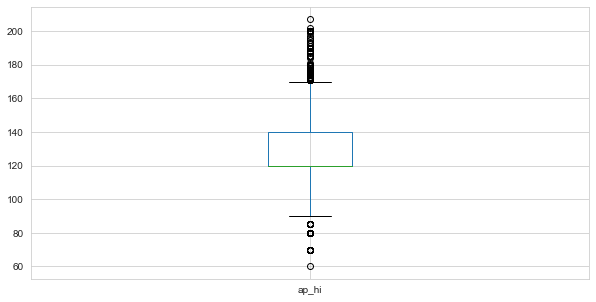

In [25]:
boxplot_col('ap_hi');

In [26]:
train_data.sort_values(by='ap_hi', ascending=False).tail(15)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
36305,42,1,168,68,70,120,1,1,1,0,0,0
23703,47,0,160,60,70,110,1,1,0,0,1,0
4830,46,1,159,68,70,100,1,1,0,0,0,0
7076,58,0,154,61,70,50,2,2,0,1,0,0
11951,43,1,160,52,70,40,1,1,1,0,1,0
33493,42,0,171,69,70,110,1,1,0,1,1,0
16629,39,0,162,57,70,50,1,1,0,0,1,0
14269,63,0,167,77,70,110,1,1,0,0,0,0
54447,44,0,156,59,70,110,1,1,0,1,1,0
20697,61,0,165,61,70,110,1,3,0,0,0,0


**Ремарка**: здесь мы видим, что некоторые значения в ap_hi меньше, чем в ap_lo. Предположим, что они перепутаны местами, поэтому вернёмся к ним позже - после работы с колонкой ap_lo.

### Версия 2 ###

In [27]:
train_data['ap_hi'].describe()

count    69894.000000
mean       126.926575
std         16.900997
min         60.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        207.000000
Name: ap_hi, dtype: float64

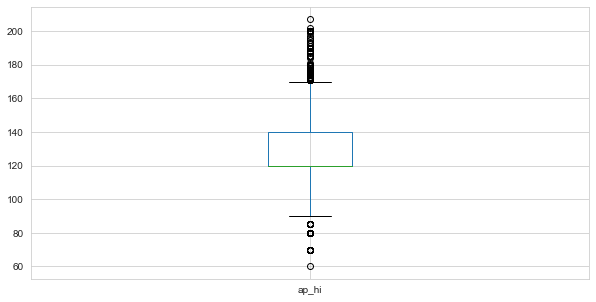

In [28]:
train_data = train_data.query('ap_hi < 250 & ap_hi >= 40')
boxplot_col('ap_hi');

## ap_lo ##

In [29]:
train_data['ap_lo'].describe()

count    69894.000000
mean        96.486551
std        188.123545
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

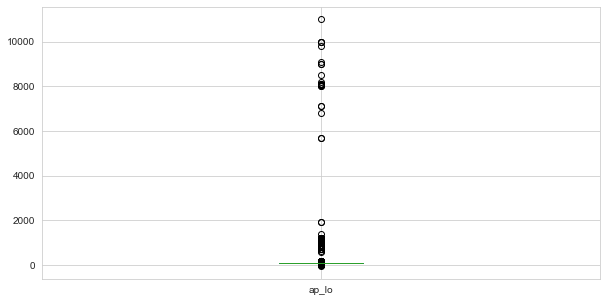

In [30]:
train_data.query('ap_lo >= 2000')
boxplot_col('ap_lo');

In [31]:
train_data.loc[train_data['ap_lo'] > 500, 'ap_lo'] = train_data['ap_lo'] / 100
test_data.loc[test_data['ap_lo'] > 500, 'ap_lo'] = test_data['ap_lo'] / 100

train_data.query('ap_lo > 500')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


<function __main__.boxplot_col(column)>

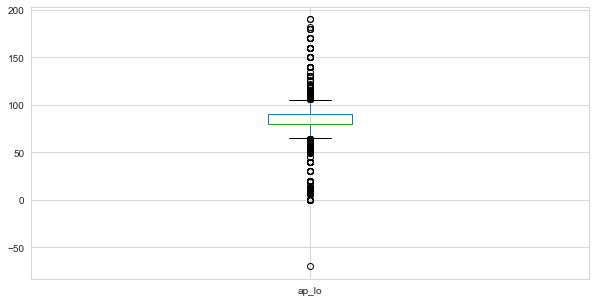

In [32]:
boxplot_col('ap_lo')

In [33]:
train_data.query('ap_lo < 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,61,0,167,74,150,-70.0,1,1,0,0,1,1


In [34]:
train_data['ap_lo'] = train_data['ap_lo'].abs()
test_data['ap_lo'] = test_data['ap_lo'].abs()

In [35]:
train_data.query('ap_lo == 0').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
13489,41,1,150,60,130,0.0,1,1,0,0,0,0
16459,56,0,156,50,138,0.0,3,1,0,0,1,1
17381,49,0,164,78,138,0.0,1,1,0,0,1,0
22923,58,1,166,68,149,0.0,1,1,0,0,1,1
25454,49,1,176,73,120,0.0,1,1,0,0,1,0
27686,64,1,180,73,140,0.0,1,1,1,1,1,1
38370,63,1,170,81,148,0.0,1,1,0,0,1,0
43922,51,0,164,78,108,0.0,2,1,0,0,1,0
45835,53,1,165,70,140,0.0,3,1,1,0,1,0
48049,52,0,160,84,121,0.0,1,1,0,0,0,1


In [36]:
train_data = train_data.query('ap_lo > 0')

In [37]:
train_data.query('ap_lo <= 15').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
56927,50,0,155,76,70,15.00,1,1,0,1,1,1
49217,43,0,163,77,200,14.00,1,1,0,0,1,1
59433,63,0,158,89,176,12.11,3,2,0,1,1,1
67474,53,0,161,93,160,12.00,3,1,0,0,0,1
25696,52,0,146,74,180,12.00,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
69320,57,1,168,63,120,6.02,1,1,0,0,0,0
68568,42,0,163,71,110,6.00,1,1,0,0,1,0
28065,55,0,161,52,90,6.00,1,1,0,0,1,0
64409,57,1,173,94,130,5.85,2,1,0,0,1,1


In [38]:
train_data.loc[train_data['ap_lo'] <= 21, 'ap_lo'] = train_data['ap_lo'] * 10
test_data.loc[test_data['ap_lo'] <= 21, 'ap_lo'] = test_data['ap_lo'] * 10

train_data.query('ap_lo <= 15').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
35140,57,0,146,55,130,10.0,1,1,0,0,0,0


In [39]:
train_data.query('ap_lo <= 50').sort_values(by='ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,0,147,41,80,50.0,1,1,0,0,1,0
45554,47,0,156,55,90,50.0,1,1,0,0,1,1
32422,39,0,152,40,90,50.0,1,1,0,0,1,0
32679,53,0,160,58,127,50.0,1,1,0,0,1,0
34104,53,0,165,62,90,50.0,3,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
33262,55,1,174,91,120,30.0,1,1,0,0,1,1
5333,57,0,164,102,120,30.0,2,1,0,0,1,0
418,45,0,157,72,150,30.0,1,1,0,0,1,1
36958,49,0,171,82,160,30.0,1,1,0,0,0,1


In [40]:
train_data = train_data.query('ap_lo >= 40')

train_data.query('ap_lo <= 50').sort_values(by = 'ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,0,147,41,80,50.0,1,1,0,0,1,0
45554,47,0,156,55,90,50.0,1,1,0,0,1,1
32679,53,0,160,58,127,50.0,1,1,0,0,1,0
34104,53,0,165,62,90,50.0,3,1,0,0,1,1
481,53,0,158,86,160,50.0,2,3,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
46155,53,1,175,73,130,40.0,1,1,0,0,0,0
45951,42,0,158,47,70,40.0,1,1,0,0,1,0
42446,62,1,166,98,130,40.0,1,1,0,0,1,1
43137,60,0,170,120,160,40.0,3,3,0,0,1,1


In [41]:
train_data.loc[
    (train_data['ap_lo'] <= 50) & 
    (train_data['ap_hi'] > 100), 
    'ap_lo'] = train_data['ap_lo'].drop(train_data.index, axis=0)

In [42]:
train_data.query('ap_lo <= 50').sort_values(by = 'ap_lo', ascending=False)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
383,53,0,147,41,80,50.0,1,1,0,0,1,0
1960,47,0,155,50,90,50.0,1,1,0,0,1,0
35047,46,1,172,58,100,50.0,1,1,1,0,1,0
38103,59,0,164,58,90,50.0,1,1,0,0,1,0
39718,51,0,162,51,90,50.0,1,1,0,0,0,0
41727,39,0,161,46,80,50.0,1,1,0,0,0,0
43233,49,1,172,75,80,50.0,2,2,0,0,1,1
45320,47,0,160,47,90,50.0,2,1,0,0,1,0
45554,47,0,156,55,90,50.0,1,1,0,0,1,1
45556,48,0,157,57,90,50.0,1,1,0,0,1,0


**Теперь вернёмся к нашей гипотезе, при которой в некоторых случаях значения ap_hi и ap_lo перепутаны.**

In [43]:
train_data.query('ap_hi < ap_lo')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,52,0,156,65,120,150.0,2,1,0,0,1,0
636,56,1,169,68,70,110.0,1,1,0,0,1,0
2384,64,0,154,102,90,150.0,1,1,0,0,0,1
2990,60,1,182,90,80,140.0,3,3,0,0,1,1
3447,54,1,180,80,80,125.0,3,3,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
66657,53,1,160,81,80,120.0,3,3,1,1,1,1
67421,64,0,153,74,80,130.0,1,1,0,0,1,1
67470,58,1,172,57,80,120.0,1,1,1,0,1,1
68067,50,0,152,65,80,120.0,1,1,0,0,1,0


**Пофиксить**

In [44]:
# вар.1: удаляем строки, где ap_lo > ap_hi
train_data = train_data.query('ap_hi > ap_lo')

<function __main__.boxplot_col(column)>

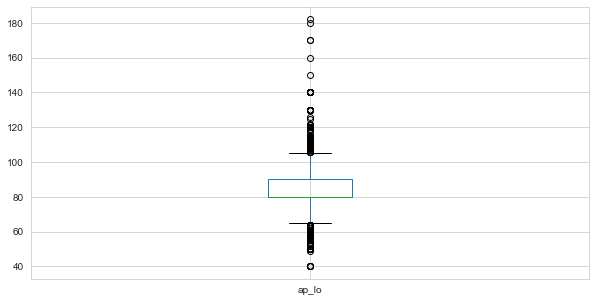

In [45]:
boxplot_col('ap_lo')

In [46]:
train_data = train_data.query('ap_lo <= 140')

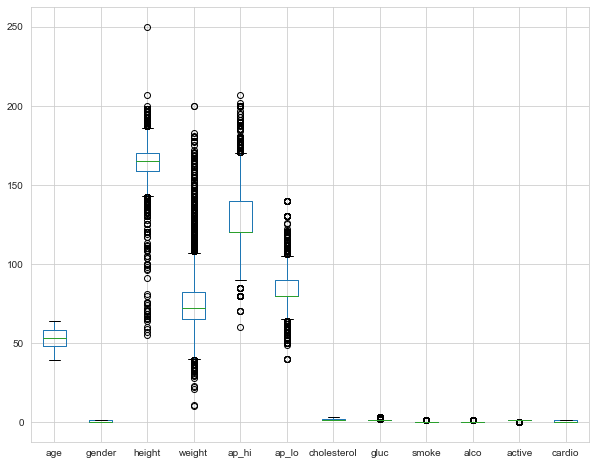

In [47]:
train_data.boxplot(figsize=(10,8));

### Версия 2 ###

In [48]:
train_data['ap_lo'].describe()

count    69709.000000
mean        81.560134
std          9.599887
min         40.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        140.000000
Name: ap_lo, dtype: float64

<function __main__.boxplot_col(column)>

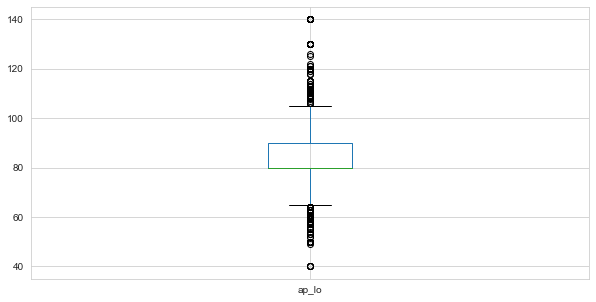

In [49]:
train_data = train_data.query('ap_lo >= 20 & ap_lo <= 200')

boxplot_col('ap_lo')

## height ##

<function __main__.boxplot_col(column)>

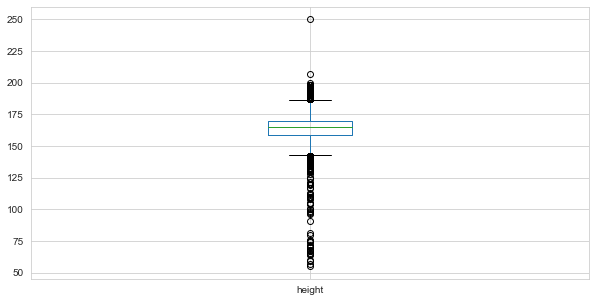

In [50]:
boxplot_col('height')

In [51]:
train_data.query('height > 215 or height < 100').sort_values(by='height')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
22723,64,0,55,81,130,90.0,1,1,0,0,1,1
66643,51,0,57,61,130,90.0,1,1,0,0,1,1
64115,50,0,59,57,125,67.0,1,1,0,0,0,0
29157,52,0,60,69,110,70.0,1,1,0,0,0,0
27603,57,0,64,61,130,70.0,1,1,0,0,1,0
44490,52,0,65,60,120,80.0,1,1,0,0,1,0
33607,53,1,65,72,130,80.0,1,1,0,0,0,0
64454,58,0,66,63,120,80.0,1,1,0,0,0,1
14323,60,0,67,57,120,90.0,1,1,0,0,1,1
53344,56,1,67,80,120,80.0,1,1,0,0,0,1


In [52]:
train_data = train_data.query('height > 120 & height < 225')

<function __main__.boxplot_col(column)>

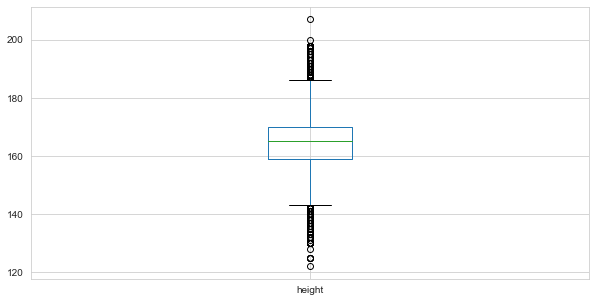

In [53]:
boxplot_col('height')

In [54]:
train_data['ap_lo'] = train_data['ap_lo'].astype('int64')
train_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168,62,110,80,1,1,0,0,1,0
1,55,0,156,85,140,90,3,1,0,0,1,1
2,51,0,165,64,130,70,3,1,0,0,0,1
3,48,1,169,82,150,100,1,1,0,0,1,1
4,47,0,156,56,100,60,1,1,0,0,0,0


### Версия 2 ###

<function __main__.boxplot_col(column)>

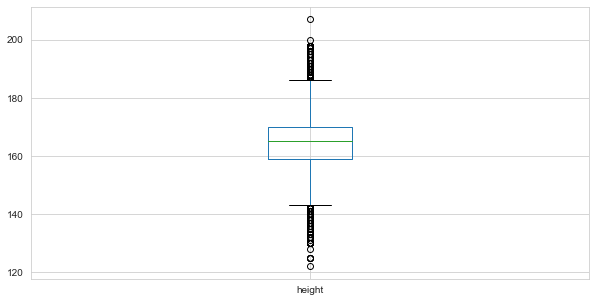

In [55]:
train_data = train_data.query('height >= 120 & height <= 215')
boxplot_col('height')

## weight ##

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69622 non-null  int32
 1   gender       69622 non-null  int64
 2   height       69622 non-null  int64
 3   weight       69622 non-null  int64
 4   ap_hi        69622 non-null  int64
 5   ap_lo        69622 non-null  int64
 6   cholesterol  69622 non-null  int64
 7   gluc         69622 non-null  int64
 8   smoke        69622 non-null  int64
 9   alco         69622 non-null  int64
 10  active       69622 non-null  int64
 11  cardio       69622 non-null  int64
dtypes: int32(1), int64(11)
memory usage: 6.6 MB


<function __main__.boxplot_col(column)>

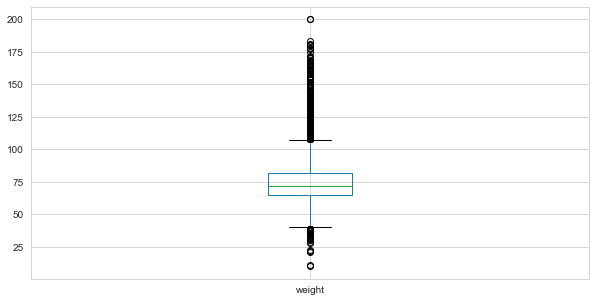

In [56]:
train_data.info()
boxplot_col('weight')

In [57]:
train_data.query('weight >= 150 & cardio == 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
389,45,1,165,169,120,80,1,1,0,0,1,0
435,45,0,186,200,130,70,1,1,0,0,0,0
2458,64,1,159,165,130,70,1,1,0,0,0,0
3413,39,0,159,159,100,80,1,1,0,0,1,0
4004,57,0,176,150,160,110,2,1,0,0,0,0
8423,40,0,170,165,120,80,1,1,0,0,1,0
14520,60,0,170,165,120,80,1,1,0,0,1,0
16384,49,1,170,156,150,90,1,3,0,0,0,0
18641,40,1,178,152,140,90,2,2,0,0,1,0
20092,56,1,165,178,120,80,1,1,1,1,1,0


In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          69622 non-null  int32
 1   gender       69622 non-null  int64
 2   height       69622 non-null  int64
 3   weight       69622 non-null  int64
 4   ap_hi        69622 non-null  int64
 5   ap_lo        69622 non-null  int64
 6   cholesterol  69622 non-null  int64
 7   gluc         69622 non-null  int64
 8   smoke        69622 non-null  int64
 9   alco         69622 non-null  int64
 10  active       69622 non-null  int64
 11  cardio       69622 non-null  int64
dtypes: int32(1), int64(11)
memory usage: 6.6 MB


In [59]:
train_data.loc[
    (train_data['weight'] >= 150) & 
    (train_data['cardio'] == 0)] = train_data.drop(train_data.index, axis=0)

In [60]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69603 non-null  float64
 1   gender       69603 non-null  float64
 2   height       69603 non-null  float64
 3   weight       69603 non-null  float64
 4   ap_hi        69603 non-null  float64
 5   ap_lo        69603 non-null  float64
 6   cholesterol  69603 non-null  float64
 7   gluc         69603 non-null  float64
 8   smoke        69603 non-null  float64
 9   alco         69603 non-null  float64
 10  active       69603 non-null  float64
 11  cardio       69603 non-null  float64
dtypes: float64(12)
memory usage: 8.9 MB


In [61]:
train_data.query('weight >= 150 & cardio == 0')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio


<function __main__.boxplot_col(column)>

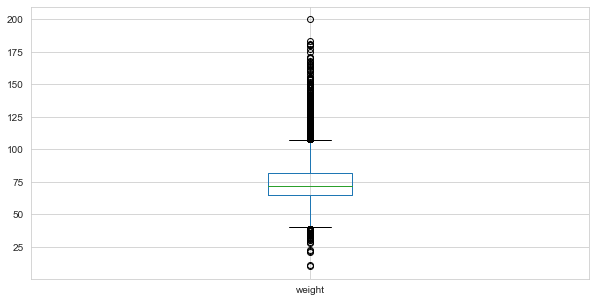

In [62]:
boxplot_col('weight')

In [63]:
train_data.query('weight < 35')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
14722,62.0,0.0,143.0,34.0,100.0,70.0,1.0,1.0,0.0,0.0,1.0,0.0
16906,47.0,1.0,170.0,31.0,150.0,90.0,2.0,2.0,0.0,0.0,1.0,1.0
18559,49.0,0.0,160.0,30.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,1.0
22016,42.0,0.0,146.0,32.0,100.0,70.0,1.0,1.0,0.0,0.0,0.0,0.0
26806,63.0,0.0,157.0,23.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
29488,55.0,1.0,177.0,22.0,120.0,80.0,1.0,1.0,1.0,1.0,1.0,0.0
33511,57.0,0.0,153.0,34.0,110.0,70.0,3.0,3.0,0.0,0.0,1.0,1.0
33817,59.0,1.0,178.0,11.0,130.0,90.0,1.0,1.0,0.0,0.0,1.0,1.0
34276,40.0,1.0,128.0,28.0,120.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
35314,54.0,0.0,146.0,32.0,130.0,80.0,1.0,2.0,0.0,0.0,0.0,0.0


In [64]:
train_data.loc[
    (train_data['height'] >= 160) & 
    (train_data['weight'] < 45)] = train_data.drop(train_data.index, axis=0)
train_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.0,1.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0,0.0
1,55.0,0.0,156.0,85.0,140.0,90.0,3.0,1.0,0.0,0.0,1.0,1.0
2,51.0,0.0,165.0,64.0,130.0,70.0,3.0,1.0,0.0,0.0,0.0,1.0
3,48.0,1.0,169.0,82.0,150.0,100.0,1.0,1.0,0.0,0.0,1.0,1.0
4,47.0,0.0,156.0,56.0,100.0,60.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
69995,52.0,1.0,168.0,76.0,120.0,80.0,1.0,1.0,1.0,0.0,1.0,0.0
69996,61.0,0.0,158.0,126.0,140.0,90.0,2.0,2.0,0.0,0.0,1.0,1.0
69997,52.0,1.0,183.0,105.0,180.0,90.0,3.0,1.0,0.0,1.0,0.0,1.0
69998,61.0,0.0,163.0,72.0,135.0,80.0,1.0,2.0,0.0,0.0,0.0,1.0


In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69622 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69556 non-null  float64
 1   gender       69556 non-null  float64
 2   height       69556 non-null  float64
 3   weight       69556 non-null  float64
 4   ap_hi        69556 non-null  float64
 5   ap_lo        69556 non-null  float64
 6   cholesterol  69556 non-null  float64
 7   gluc         69556 non-null  float64
 8   smoke        69556 non-null  float64
 9   alco         69556 non-null  float64
 10  active       69556 non-null  float64
 11  cardio       69556 non-null  float64
dtypes: float64(12)
memory usage: 8.9 MB


In [66]:
train_data = train_data.dropna()

In [67]:
train_data[['age','gender',#'height',
            'weight','ap_hi',#'ap_lo',
            'cholesterol','gluc','smoke',
            'alco','active','cardio']] = \
train_data[['age','gender',#'height',
            'weight','ap_hi',#'ap_lo',
            'cholesterol','gluc','smoke',
            'alco','active','cardio']].astype('int64')

C:\Users\Home\AppData\Local\Temp\ipykernel_284\2195051912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['age','gender',#'height',


In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69556 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          69556 non-null  int64  
 1   gender       69556 non-null  int64  
 2   height       69556 non-null  float64
 3   weight       69556 non-null  int64  
 4   ap_hi        69556 non-null  int64  
 5   ap_lo        69556 non-null  float64
 6   cholesterol  69556 non-null  int64  
 7   gluc         69556 non-null  int64  
 8   smoke        69556 non-null  int64  
 9   alco         69556 non-null  int64  
 10  active       69556 non-null  int64  
 11  cardio       69556 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.9 MB


In [69]:
train_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168.0,62,110,80.0,1,1,0,0,1,0
1,55,0,156.0,85,140,90.0,3,1,0,0,1,1
2,51,0,165.0,64,130,70.0,3,1,0,0,0,1
3,48,1,169.0,82,150,100.0,1,1,0,0,1,1
4,47,0,156.0,56,100,60.0,1,1,0,0,0,0


<AxesSubplot:>

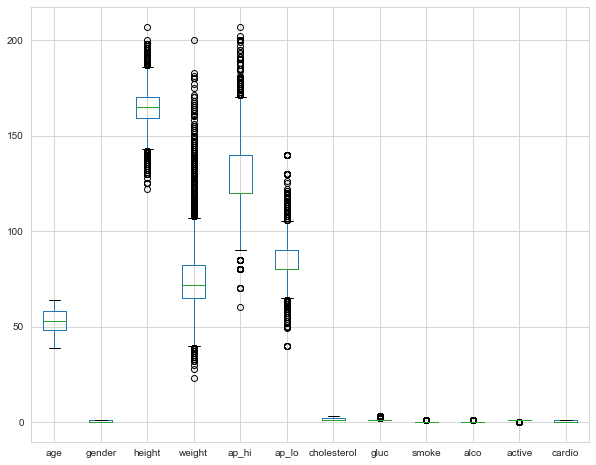

In [70]:
train_data.boxplot(figsize=(10,8))

In [71]:
test_data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,51,1,154,85.0,130,80.0,1,1,0,0,1
1,52,2,170,69.0,130,90.0,1,1,0,0,1
2,55,1,160,70.0,120,75.0,1,1,0,0,0
3,49,2,185,94.0,130,90.0,1,1,0,0,1
4,44,2,170,76.0,120,80.0,1,1,0,0,1


### Версия 2 ###

<function __main__.boxplot_col(column)>

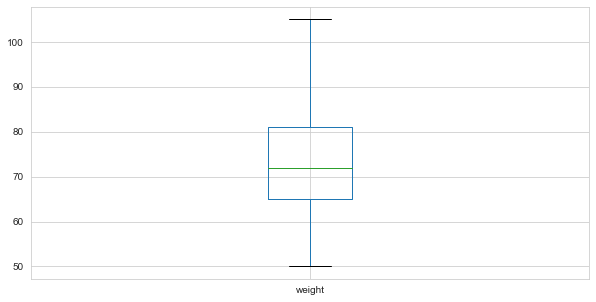

In [72]:
train_data = train_data.query('weight >= 50 & weight <= 105')
boxplot_col('weight')

## total_eda ###

In [73]:
display(train_data.head())
display(test_data)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,1,168.0,62,110,80.0,1,1,0,0,1,0
1,55,0,156.0,85,140,90.0,3,1,0,0,1,1
2,51,0,165.0,64,130,70.0,3,1,0,0,0,1
3,48,1,169.0,82,150,100.0,1,1,0,0,1,1
4,47,0,156.0,56,100,60.0,1,1,0,0,0,0


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,51,1,154,85.0,130,80.0,1,1,0,0,1
1,52,2,170,69.0,130,90.0,1,1,0,0,1
2,55,1,160,70.0,120,75.0,1,1,0,0,0
3,49,2,185,94.0,130,90.0,1,1,0,0,1
4,44,2,170,76.0,120,80.0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,59,2,170,103.0,150,90.0,1,1,0,1,0
29996,50,1,172,78.0,110,70.0,1,1,0,0,1
29997,58,2,169,61.0,120,80.0,1,1,0,0,0
29998,39,2,175,80.0,120,80.0,2,1,0,0,0


<AxesSubplot:>

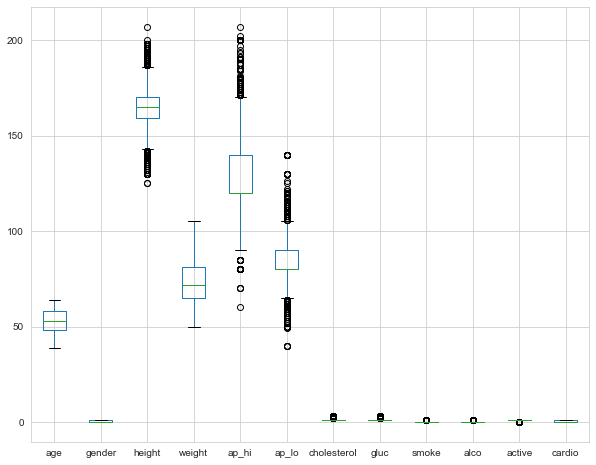

In [74]:
train_data.boxplot(figsize=(10,8))

# Modeling #

In [75]:
features_train = train_data.drop('cardio', axis=1)
target_train = train_data['cardio']

RANDOM_SCORE = 69

In [76]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)

## std_scaler ##

In [77]:
#
#best_forest_cvs = 0
#best_forest_est = 0
#best_forest_depth = 0
#best_forest_leaf = 0
#
#for est in tqdm(range(1, 60, 1)):
#    for depth in range(1, 15, 1):
#        for leaf in range(2, 5, 1):
#                forest_model = RandomForestClassifier(max_depth = depth, 
#                                                      n_estimators = est,
#                                                      min_samples_leaf=leaf,
#                                                      random_state = RANDOM_SCORE)
#                forest_model.fit(features_train, target_train)
#            
#                forest_cvs = cross_val_score(forest_model, features_train_scaled, target_train, 
#                                             cv=5, scoring='roc_auc').mean()
#            
#                if forest_cvs > best_forest_cvs:
#                    best_forest_cvs = forest_cvs
#                    best_forest_est = est
#                    best_forest_depth = depth
#                    best_forest_leaf = leaf
#                
#print('Best cvs for RF:', best_forest_cvs)
#print('Best depth for RF:', best_forest_depth)
#print('Best est for RF:', best_forest_est)
#print('Best leaf for RF:', best_forest_leaf)
#print('')

In [78]:
#best_forest_model = RandomForestClassifier(max_depth = 9, 
#                                           n_estimators = 39,
#                                           min_samples_leaf = 3,
#                                           random_state = RANDOM_SCORE)
#best_forest_model.fit(features_train, target_train)
#
#best_forest_cvs = cross_val_score(best_forest_model, features_train, target_train, cv=5, scoring='roc_auc').mean()
#
#print(best_forest_cvs)

In [79]:
from sklearn.model_selection import GridSearchCV
#from sklearn.svm import SVC
#import warnings
##with warnings.catch_warnings():
#warnings.filterwarnings('ignore', 'Solver terminated early.*')
#
#parameters = [
#    {
#    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'], 
#    'C': [1,2,3],
#    'max_iter': [1500,10000]
#    }
#]
#    
#gscv_lr = GridSearchCV(SVC(), param_grid = parameters, scoring='roc_auc')
#gscv_lr.fit(features_train_scaled, target_train)
#
#sorted(gscv_lr.cv_results_.keys())
#

In [80]:
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

'''
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': (3, 50, 1),
        'seed': 0
    }
'''


'\nspace={\'max_depth\': hp.quniform("max_depth", 3, 18, 1),\n        \'gamma\': hp.uniform (\'gamma\', 1,9),\n        \'reg_alpha\' : hp.quniform(\'reg_alpha\', 40,180,1),\n        \'reg_lambda\' : hp.uniform(\'reg_lambda\', 0,1),\n        \'colsample_bytree\' : hp.uniform(\'colsample_bytree\', 0.5,1),\n        \'min_child_weight\' : hp.quniform(\'min_child_weight\', 0, 10, 1),\n        \'n_estimators\': (3, 50, 1),\n        \'seed\': 0\n    }\n'

In [81]:
'''
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']), min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(features_train_scaled, target_train), (features_train, target_train)]
    
    clf.fit(features_train_scaled, target_train,
            eval_set=evaluation, eval_metric="roc_auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }
    '''

'\ndef objective(space):\n    clf=xgb.XGBClassifier(\n                    n_estimators =space[\'n_estimators\'], max_depth = int(space[\'max_depth\']), gamma = space[\'gamma\'],\n                    reg_alpha = int(space[\'reg_alpha\']), min_child_weight=int(space[\'min_child_weight\']),\n                    colsample_bytree=int(space[\'colsample_bytree\']))\n    \n    evaluation = [(features_train_scaled, target_train), (features_train, target_train)]\n    \n    clf.fit(features_train_scaled, target_train,\n            eval_set=evaluation, eval_metric="roc_auc",\n            early_stopping_rounds=10,verbose=False)\n    \n\n    pred = clf.predict(X_test)\n    accuracy = accuracy_score(y_test, pred>0.5)\n    print ("SCORE:", accuracy)\n    return {\'loss\': -accuracy, \'status\': STATUS_OK }\n    '

In [ ]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="roc_auc",
                    cv=3)

grid.fit(features_train, target_train)

# Total classification #

# Conclusion #

In [87]:
subsample['cardio'] = grid.predict_proba(test_data)[:,1]
subsample

,id,cardio
0,5,0.477784
1,6,0.563444
2,7,0.421128
3,10,0.513171
4,11,0.227348
...,...,...
29995,99984,0.869132
29996,99987,0.200240
29997,99989,0.458544
29998,99994,0.329247


In [88]:
subsample['cardio'].value_counts()
test_data

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,51,1,154,85.0,130,80.0,1,1,0,0,1
1,52,2,170,69.0,130,90.0,1,1,0,0,1
2,55,1,160,70.0,120,75.0,1,1,0,0,0
3,49,2,185,94.0,130,90.0,1,1,0,0,1
4,44,2,170,76.0,120,80.0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
29995,59,2,170,103.0,150,90.0,1,1,0,1,0
29996,50,1,172,78.0,110,70.0,1,1,0,0,1
29997,58,2,169,61.0,120,80.0,1,1,0,0,0
29998,39,2,175,80.0,120,80.0,2,1,0,0,0


In [91]:
subsample.to_csv('D:/sample_submission_gridsearch.csv', index=False)

In [93]:
y = pd.read_csv('D:/sample_submission_gridsearch.csv')
y

,id,cardio
0,5,0.477784
1,6,0.563444
2,7,0.421128
3,10,0.513171
4,11,0.227348
...,...,...
29995,99984,0.869132
29996,99987,0.200240
29997,99989,0.458544
29998,99994,0.329247


In [95]:
with open("D:/workplace/data_science/pycharm/mvp_workshop/xgb_grid_clf.pcl", 'wb') as fid:
    dump(grid, fid)

In [ ]:
open = load(open(r'D:\workplace\data_science\pycharm\mvp_workshop\xgb_grid_clf.pcl', 'rb'))
open

In [ ]:
with open(r'D:\workplace\data_science\pycharm\mvp_workshop\xgb_grid_clf.pcl', 'wb') as fid:
    load(fid)

In [100]:
with open(r'D:\workplace\data_science\pycharm\mvp_workshop\xgb_grid_clf.pcl', 'wb') as fid:
    load(fid)

TypeError: 'GridSearchCV' object is not callable